In [1]:
import matplotlib.pyplot as plt
from t4gpd.io.CirReader import CirReader
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import geopandas
from math import *
from numpy.random import randint
from shapely.geometry import LineString,Point
from t4gpd.commons.GeomLib import GeomLib
from t4gpd.demos.GeoDataFrameDemos import GeoDataFrameDemos
from t4gpd.morph.geoProcesses.FootprintExtruder import FootprintExtruder
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
import random

In [24]:
def VerticalVF(a,b):#a = y/w , b = x/w
    f = 1/(pi*b)*(b*atan(1/b)+a*atan(1/a)-((a**2+b**2)**0.5)*atan(1/((a**2+a**2)**0.5))+0.25*log((1+b**2)*(1+a**2)/(1+b**2+a**2)*((b**2*(1+b**2+a**2)/((1+b**2)*(b**2+a**2)))**(b**2))*(a**2*(1+a**2+b**2)/((1+a**2)*(a**2+b**2)))**(a**2)))
    return f

In [25]:
def SurfaceNormal(self): #input is the buildingsIn3d.geometry[i],than choose the polygon of one facet
    coord = self.exterior.coords
    facet_p0=np.array(coord[0])
    facet_p1=np.array(coord[1])
    facet_p2=np.array(coord[2])
    vec1 = facet_p1 - facet_p0
    vec2 = facet_p2 - facet_p1
    a = vec1[1]*vec2[2]-vec1[2]*vec2[1]
    b = vec1[2]*vec2[0]-vec1[0]*vec2[2]
    c = vec1[0]*vec2[1]-vec1[1]*vec2[0]
    normal = np.array([a,b,c])
    mod = module(normal)
    n  = normal/mod
    return n

In [26]:
def module(vector):
    return np.sqrt(np.dot(np.array(vector),np.array(vector)))

In [27]:
def RandomDir(n):#number of samples
    vector = []
    for i in range(n):
        polar = 0.5*np.arccos(1-2*random.random())
        azimuth = random.random()*pi*2
        x = cos(polar)*sin(azimuth)
        y = sin(polar)
        z = cos(polar)*cos(azimuth)
        vector.append(np.array([x,y,z]))
    return vector

In [28]:
def RayPoint(point,n,norm,length):
    ray_line = []
    vec = RandomDir(n)
    for i in range(len(vec)):
        vec1 = vec[i]
        x2 = norm[0]*vec1[1]+norm[1]*vec1[0]
        y2 = norm[1]*vec1[1]-norm[0]*vec1[0]
        z2 = vec1[2]
        p2 = Point(point.x+x2*length,point.y+y2*length,point.z+z2*length)
        line = LineString([point,p2])
        ray_line.append(line)
    line_geo = GeoDataFrame({'geometry':ray_line},crs='epsg:2154')
    return line_geo

In [29]:
def RayPoint2(point,n,norm,length):
    ray_line = []
    vec = RandomDir(n)
    for i in range(len(vec)):
        vec1 = vec[i]
        x2 = norm[0]*vec1[1]+norm[1]*vec1[0]
        y2 = norm[1]*vec1[1]-norm[0]*vec1[0]
        z2 = vec1[2]
        p2 = Point(point.x+x2*length,point.y+y2*length,point.z+z2*length)
        ray_vec = np.array([p2.x,p2.y,p2.z]) - np.array([point.x,point.y,point.z])
        ray_line.append(ray_vec)
    return ray_line

In [30]:
def cmp(a,b,c=1e-3):
    return abs(a-b)<c

In [31]:
def intersection(ray,sensor,surface):
    n = SurfaceNormal(surface)
    coords = surface.exterior.coords
    point = np.array(sensor.geometry)
    vec = np.array(coords[1])-point
    con1 = ray.dot(n)
    con2 = vec.dot(n)
    ratio = con2/con1
    if con1>0:
        return False
    else:
        in_point = point + ratio*ray
        if OnSurface(surface,Point(in_point)):
            return ratio
        else:
            return False  

In [32]:
def OnSurface(self,point):
    ang = 0
    p = np.array(point)
    coord = self.exterior.coords
    for i in range(len(coord)-1):
        vec1 = np.array(coord[i]) - p
        vec2 = np.array(coord[i+1])-p
        m1 = module(vec1)
        m2 = module(vec2)
        if cmp(m1*m2,0):
            return True
        else:
            cost = np.dot(vec1,vec2)/(m1*m2)
        if cost>1:
            cost = 1
        if cost<-1:
            cost = -1
        ang = ang +np.arccos(cost)
    return cmp(ang,2*np.pi)

In [33]:
def SelectRay(vec0,vec1,ray,method):#transform into 2d
    if method=='horizontal':
        v0 = np.array([vec0[0],vec0[1]])#here v0 is the left point
        v1 = np.array([vec1[0],vec1[1]])
        r = np.array([ray[0],ray[1]])
    if method=='vertical':
        v0 = np.array([vec0[1],vec0[2]])#here v0 is the taller point
        v1 = np.array([vec1[1],vec1[2]])
        r = np.array([ray[1],ray[2]])

    x = v0[0]*r[1]-v0[1]*r[0]
    y = v1[0]*r[1]-v1[1]*r[0]
    if x<=0 and y>=0:
        return True
    else:
        return False

In [34]:
def CrossProduct(vec0,vec1):
    x = vec0[1]*vec1[2]-vec0[2]*vec1[1]
    y = vec1[0]*vec0[2]-vec0[0]*vec1[2]
    z = vec0[0]*vec1[1]-vec1[0]*vec0[1]
    return np.array([x,y,z])

In [37]:
def VectorAngle(vector1,vector2):#calculate the angle between two vectors
    unit_vector1 = vector1/np.linalg.norm(vector1)
    unit_vector2 = vector2/np.linalg.norm(vector2)
    dot_vector = np.dot(unit_vector1,unit_vector2)
    return np.arccos(dot_vector)

In [36]:
def STEvenPoints(face,n,m): #row=n, column=m
    p = face.exterior.coords
    vec1 = np.array(p[2])-np.array(p[1])
    vec2 = np.array(p[1])-np.array(p[0])
    L1 = vec1/n
    L2 = vec2/m
    s = []
    normal = []
    for i in range(1,n+1):
        for j in range(1,m+1):
            point_1 = np.array(p[0])+L2*(j-1)+L1*(i-1)
            point_2 = np.array(p[0])+L2*j+L1*i
            point_c = Point((point_1+point_2)/2)
            s.append(point_c)
            normal.append(SurfaceNormal(face))
    p_geodata = GeoDataFrame({'geometry':s},crs='epsg:2154')
    p_geodata['NormalVector'] = normal
    return p_geodata

In [38]:
polygon1 = []
polygon2 = []
coords_3d_1 = np.array([[20,0,0], [0,0,0], [0,0,15], [20,0,15], [20,0,0]])
coords_3d_2 = np.array([[0,0,0], [20,0,0], [20,15,0], [0,15,0], [0,0,0]])
polygon1.append(Polygon(coords_3d_1))
polygon2.append(Polygon(coords_3d_2))
f1 = GeoDataFrame({'geometry':polygon1},crs='epsg:2154')
f2 = GeoDataFrame({'geometry':polygon2},crs='epsg:2154')

In [39]:
normal1 = []
normal2 = []
normal1.append(SurfaceNormal(f1.geometry[0]))
normal2.append(SurfaceNormal(f2.geometry[0]))
f1['NormalVector'] = normal1
f2['NormalVector'] = normal2
f1['floor'] = 10

In [41]:
normal = []
sensors = STEvenPoints(f1.geometry[0],3,4)
for i in range(len(sensors)):
    normal.append(normal1)

In [42]:
scene1 = ToUnstructuredGrid([f1,f2,sensors]).run()
scene1.plot(point_size=10.0, render_points_as_spheres=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [56]:
import timeit
vf = pd.DataFrame(np.zeros((10,3)))
time = []
nb_ray = [100,1000,5000]
coords = f2.geometry[0].exterior.coords

for i in range(len(nb_ray)):
    start = timeit.default_timer()
    nb_cal = []
    for w in range(10):
        nb=0
        for s in range(len(sensors)):
            p = sensors.iloc[s]
            normal = sensors.NormalVector[s]
            ray = RayPoint2(p.geometry,nb_ray[i],normal,20)
            f2['nray'] = 0
            point = np.array(p.geometry)
            vec0 = np.array(coords[0])-point
            vec1 = np.array(coords[1])-point
            vec2 = np.array(coords[2])-point
            ray_vec = ray
            for j in range(len(ray)):
                if SelectRay(vec2,vec1,ray[j],'vertical')==True and SelectRay(vec2,vec1,ray[j],'horizontal')==True:
                    ray_vec.append(ray[j])
            for a in range(len(ray_vec)):
                ratio = []
                value = intersection(ray_vec[a],p,f2.geometry[0])
                if value==False:
                    ratio.append(100)
                else:
                    ratio.append(value)
                f2['ratio'] = ratio
                mymin = min(f2.ratio)
                if f2.ratio[0]!=100:
                    f2.loc[0,'nray'] = f2.loc[0,'nray']+1
            nbs = f2.nray
            nb = nb + nbs
        nb_cal.append(nb/(len(sensors)*nb_ray[i]))
    vf[i] = nb_cal
    stop = timeit.default_timer()
    time.append(stop-start)

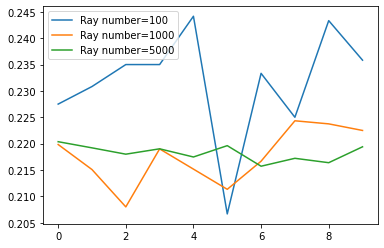

In [57]:
plt.plot(vf[0],label='Ray number=100')
plt.plot(vf[1],label='Ray number=1000')
plt.plot(vf[2],label='Ray number=5000')
#plt.plot(vf[3],label='Ray number=10000')
plt.legend()
plt.savefig('test2.png')

In [62]:
for i in range(len(vf)):
    print((np.mean(vf[i])-VerticalVF(3/4,3/4))/VerticalVF(3/4,3/4))

0.059188047016467835
-0.005277642751584813
-0.0022067594210264637


KeyError: 3

In [65]:
525/199.8

2.6276276276276276